# Empirical Tier List

Or at the very least an attempt at it.

## Methodology

Based on match data provided by babygogogo, I've tried to make a empirical tierlist of the characters in TinyWars based on how these make positive or negative contributions to the win expectation $W_e$. Given by the standard elo formula, $W_e$ can be represented as:

$$
W_e = \dfrac{1}{1 + 10^{\frac{R_o - R_p}{400}}}
$$

Where $R_o$ is the opponent's elo rating and $R_p$ is the player's own elo _at the start of the match_. Such that the performance $P$ of the character picked in a given match is calculated as:

$$
P = A - W_e
$$

Where $A$ is the actual result of the match, with a win represented as a $1$ and a loss as a $0$. In other words, the difference between the expected outcome and the actual outcome is atributed to be the CO's influence solely. As far as data from the game is concerned, that and the player index is indeed the only differences between the players going into a match.

### Sample

Only ranked or tourney matches that weren't mirror matches or ended in a draw were accounted.

### Reverse engineering the Elo's at the start of the match

The dataset baby gave us has only the player's elo ratings $R_p'$ at the end of the match, after these were corrected with the Elo update formula:

$$
R'_p = R_p + K \times (A - W_e)
$$

If you expand $W_e$, you'll see $R_p$ as a term of the expression and as an expoent, which makes this expression _non-linear_. So what I did to figure out the previous Elo's was plug into $R_p$ and $R_o$ values with various difference intervals until I got one that produced the resulting elos. The search was optimized using a [binary search algorithm](https://en.wikipedia.org/wiki/Binary_search) seen in the auxiliary function `revert_elo`.

#### Note

As the Elo formula uses floats (i.e. it has decimal values because it performs a division) the integer Elo rating we see in game are actually **rounded results**. As such, due to rounding, more than one starting Elo combination can produce the resulting Elo combination. So much so that the mathcup heatmap by the end of this notebook changes ratings slightly each time it is run. But do note the the average performance and relative position in the tier list of every character remains **stable**.

### Minimizing discrepancies due to low game counts

Some matchups are so underrepresented (i.e.: Zhao faced against Gage+ only once) that assigning a character's performance based on them would lead to severe distortions. For that reason I've used a [Weighted Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average) (WBA) to calculate the matchup performance ratings $\overline P$. The formula for the WBA is given as:

$$
\overline P = \dfrac{C \times p + \sum^n_i = 1 P_i}{C + n}
$$

Where:

- $C$ is the confidence constant, here set to 15 as it was calculated to be the average number of games per matchup.
- $p$ is the prior performance here set to 0.

So to the raw average are added 15 "phantom" games where the character pick is said to not have impacted the player's chances at all. This makes a single win less significant to that character's rating, but with more and more real games, the less significant these phantom games become.

## Dependencies

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from dataclasses import dataclass
from sqlalchemy import create_engine, select, join, func, distinct, desc, asc
from sqlalchemy.orm import sessionmaker as sm
from utils.tables import Match, Player, CO, User

## Auxliliary functions

In [2]:
def elo_win_expectation(winner_elo: int, loser_elo: int) -> float:
    return 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    
def max_elo_variation(k_factor: float = 90) -> int:
    diff = 0

    engine = create_engine("sqlite:///TinyWars.db")
    Session = sm(bind=engine)
    with Session() as session:
        highest_query = select(User).order_by(desc(User.elo)).limit(1)
        highest_player = session.execute(highest_query).scalar_one()

        # Get lowest ranked player (excluding players with None ELO)
        lowest_query = (
            select(User).where(User.elo.isnot(None)).order_by(asc(User.elo)).limit(1)
        )
        lowest_player = session.execute(lowest_query).scalar_one()
        diff = highest_player.elo - lowest_player.elo

    return int(round(diff))

def revert_elo(
    winner_new_elo: int,
    loser_new_elo: int,
    max_elo_variation: int,
    k_factor: float = 90, 
) -> tuple[int, int]:
    new_diff = float(winner_new_elo - loser_new_elo)


    def calculate_new_difference(old_diff: float) -> float:
        winner_win_exp = 1.0 / (1.0 + math.pow(10.0, -old_diff / 400.0))
        diff_change = 2 * k_factor * (1.0 - 1.0 * winner_win_exp)
        return old_diff + diff_change

    hi = max_elo_variation
    lo = -hi

    while True:
        mid = lo + (hi - lo) / 2
        mid_value = calculate_new_difference(mid)
        if mid_value < new_diff - 0.5:
            lo = mid
        elif mid_value > new_diff + 0.5:
            hi = mid
        else:
            break

    old_diff = mid
    old_winner_win_exp = 1.0 / (1.0 + math.pow(10.0, -old_diff / 400.0))
    winner_old_elo = winner_new_elo - k_factor * (1 - old_winner_win_exp)
    loser_old_elo = winner_old_elo - old_diff

    return int(round(winner_old_elo)), int(round(loser_old_elo))


@dataclass
class MatchInfo():
    player_elo: int
    opponent_elo: int
    result: int 


def matchup_rating(
    matches_data: list[MatchInfo], confidence_constant: int
) -> dict[str, float | int]:
    total_performance = 0
    match_count = len(matches_data)
    if match_count == 0:
        return total_performance, total_performance
    

    for match in matches_data:
        elo_diff = match.player_elo - match.opponent_elo
        expected_result = 1 / (1 + 10**(-elo_diff / 400))
        total_performance += match.result - expected_result
    bayesian_average = total_performance / (confidence_constant + match_count)
    raw_average = total_performance / match_count
    result = {
        "rating": bayesian_average,
        "error margin": raw_average - bayesian_average,
        "match count": match_count
    }
    return result

def display_heatmap(
    title: str,
    label: str,
    df: pd.DataFrame,
    sorted_cos: pd.Series,
    added_col: pd.Series,
    count: bool = False
) -> None:
    df.loc[sorted_cos, sorted_cos]
    addded_col = added_col[sorted_cos]
    n = len(sorted_cos)
    extended_matrix = np.full((n + 1, n + 1), 0.0)
    extended_matrix[:n, :n] = df.values
    extended_matrix[:n, n] = added_col.values
    if count:
        extended_matrix[n, :n] = added_col.values
        extended_index = sorted_cos + ['Total']
        extended_columns = sorted_cos + ['Total']
        cmap = LinearSegmentedColormap.from_list('matchup_cmap', ['white', 'green'])
        fmt='.0f'
    else:
        extended_matrix[n, :n] = -added_col.values  # Bottom row (negative averages)
        extended_index = sorted_cos + ['Average']
        extended_columns = sorted_cos + ['Average']
        cmap = LinearSegmentedColormap.from_list('matchup_cmap', ['red', 'white', 'green'])
        fmt='.3f'
    extended_df = pd.DataFrame(extended_matrix, index=extended_index, columns=extended_columns)

    # Create the heatmap
    plt.figure(figsize=(16, 14))
    # Plot heatmap
    sns.heatmap(
        extended_df,
        cmap=cmap,
        center=0,
        annot=True,
        fmt=fmt,
        mask=np.eye(n + 1, dtype=bool),
        cbar_kws={'label': label},
        square=True,
        linewidths=0.5,
        linecolor='gray'
    )
    
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add grid lines to separate the average column/row
    plt.axvline(x=n, color='black', linewidth=2)
    plt.axhline(y=n, color='black', linewidth=2)
    
    plt.tight_layout()
    plt.show()

In [3]:
ROSTER = {
    62001: "Brenner-",
    63000: "Isabella-",
    100001: "Lin",
    10001: "Will",

    40001: "Forsythe",
    53002: "Gage+",
    54002: "Tasha+",

    61000: "Greyfield+",
    64001: "Waylon+",

    110002: "Caulder",
    60000: "Penny+",
    90001: "Tabitha",

    55001: "Cassie",
    59003: "Cyrus",
    12003: "Grat",
    130002: "Hawke",
    66000: "Judy",
    16002: "Lee",
    14003: "Mira",
    65001: "Snowind",
    56001: "The Beast",
    57002: "The Fanatic",
    18003: "Tinker",
    20003: "Zhao",
}

## Query database

Fetch all matches in ranked and tourney modes where there's a character of the current roster and populate a Dataframe

In [4]:
engine = create_engine('sqlite:///TinyWars.db')
Session = sm(bind=engine)

with Session() as session:
    query = (
        select(
            Match.id.label('match_id'),
            Match.winner_id,
            Player.id.label('player_id'),
            Player.co_id,
            Player.resulting_elo,
            CO.name.label('co_name')
        )
        .select_from(
            join(Match, Player, Match.id == Player.match_id)
            .join(CO, Player.co_id == CO.id)
        )
        .where(Match.mode.in_(['ranked', 'tourney'])) # Filter by competitive settings
        .where(Match.winner_id != 0) # Exclude ties
        .where(Player.co_id.in_(ROSTER.keys())) # Filter by current character roster
    )
    result = session.execute(query)
    # Convert to DataFrame
    matches_df = pd.DataFrame(result.fetchall(), columns=[
        'match_id', 'winner_id', 'player_id', 
        'co_id', 'resulting_elo', 'co_name'
    ])
    print(matches_df.tail(10))

       match_id  winner_id  player_id   co_id  resulting_elo       co_name
10223      6950          1          1   20003           1698  Zhaotiantong
10224      6950          1          2   12003           1212          Grat
10225      6941          1          1   12003           1519          Grat
10226      6941          1          2   16002           1309           Lee
10227      6939          1          2   90001           1212       Tabitha
10228      6936          1          1  130002           1279         Hawke
10229      6936          1          2  130002           1214         Hawke
10230      6924          2          1  100001           1580           Lin
10231      6924          2          2   10001           1379          Will
10232      6916          2          2   40001           1698      Forsythe


## Create MatchInfo Objects and load it to a dictionary

Extract the information we need for the matchup analysis, reverting the update to the players Elo rankings.

In [5]:
player_count = matches_df.groupby('match_id')['match_id'].transform('size')
unique_cos = matches_df.groupby('match_id')['co_id'].transform('nunique')
matches_df = matches_df[(player_count == 2) & (unique_cos == 2)]

match_groups = matches_df.groupby('match_id')
match_info_dict: dict[tuple[int, int], list[MatchInfo]]= {}
delta = max_elo_variation()

for match_id, match_df in tqdm(match_groups, desc="Processing Match Data"):
    
    # Get player data
    player1 = match_df.iloc[0]
    player2 = match_df.iloc[1]
    co1 = player1['co_id']
    co2 = player2['co_id']
    key = (ROSTER[min(co1, co2)], ROSTER[max(co1, co2)])
    
    if key not in match_info_dict:
        match_info_dict[key] = []
    if match_df['winner_id'].iloc[0] == 1:
        winner_old_elo, loser_old_elo = revert_elo(
            player1['resulting_elo'], player2['resulting_elo'], delta
        )
        if key[0] == ROSTER[co1]:
            match_info = MatchInfo(winner_old_elo, loser_old_elo, 1)
        else:
            match_info = MatchInfo(loser_old_elo, winner_old_elo, 0)
    else:
        winner_old_elo, loser_old_elo = revert_elo(
            player2['resulting_elo'], player1['resulting_elo'], delta
        )
        if key[0] == ROSTER[co2]:
            match_info = MatchInfo(winner_old_elo, loser_old_elo, 1)
        else:
            match_info = MatchInfo(loser_old_elo, winner_old_elo, 0)

    match_info_dict[key].append(match_info)

Processing Match Data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3670/3670 [00:00<00:00, 4118.59it/s]


## For each co pairing, calculate the its matchup rating

In [6]:
matchup_results = {}
total_matches = len(matches_df['match_id'].unique())  # Count unique matches
total_pairings = len(match_info_dict)  # Count unique CO pairings
confidence_constant = int(round(total_matches / total_pairings))

for key, value in match_info_dict.items():
    matchup_results[key] = matchup_rating(value, confidence_constant)

for matchup, result in matchup_results.items():
    print(f"Matchup {matchup}: {result}")

Matchup ('Will', 'Lin'): {'rating': -0.03157399081177812, 'error margin': -0.006231708712850947, 'match count': 76}
Matchup ('Grat', 'Lee'): {'rating': -0.06857477333783017, 'error margin': -0.2571554000168631, 'match count': 4}
Matchup ('Grat', 'Zhao'): {'rating': 0.1036625167221246, 'error margin': 0.17277086120354096, 'match count': 9}
Matchup ('Grat', 'Hawke'): {'rating': -0.16143623313802746, 'error margin': -0.2690603885633791, 'match count': 9}
Matchup ('Forsythe', 'Tabitha'): {'rating': -0.18435639858262473, 'error margin': -0.07900988510683918, 'match count': 35}
Matchup ('Grat', 'Tabitha'): {'rating': -0.17766487624435084, 'error margin': -0.14026174440343486, 'match count': 19}
Matchup ('Lin', 'Hawke'): {'rating': 0.007037354927176592, 'error margin': 0.001954820813104609, 'match count': 54}
Matchup ('Zhao', 'Tabitha'): {'rating': -0.027095392185784908, 'error margin': -0.04515898697630817, 'match count': 9}
Matchup ('Grat', 'Caulder'): {'rating': -0.008063382588663518, 'err

## Create the matchup heatmap

### Create a symetric matchup matrix

In [7]:
n = len(ROSTER)
matchup_matrix = np.full((n, n), 0.0)
error_matrix = np.full((n, n), 0.0)
match_count_matrix = np.full((n,n), 0)

# Fill the matrix with matchup ratings
co_to_idx = {co: idx for idx, co in enumerate(ROSTER.values())}

for (co1, co2), rating in matchup_results.items():
    i, j = co_to_idx[co1], co_to_idx[co2]
    matchup_matrix[i, j] = rating["rating"]
    matchup_matrix[j, i] = -rating["rating"]  # Symmetric relationship
    error_matrix[i,j] = rating["error margin"]
    error_matrix[i,j] = -rating["error margin"]
    match_count_matrix[i, j] = match_count_matrix[j, i] = rating["match count"]

# Create DataFrame with proper labels
matchup_df = pd.DataFrame(matchup_matrix, index=ROSTER.values(), columns=ROSTER.values())
error_df = pd.DataFrame(error_matrix, index=ROSTER.values(), columns=ROSTER.values())
match_count_df = pd.DataFrame(
    match_count_matrix, index=ROSTER.values(), columns=ROSTER.values()
)

### Calculate average ratings, average error and total matches.

In [8]:
avg_ratings = matchup_df.copy().mean(axis=1)
avg_error = error_df.copy().mean(axis=1)
sum_matches = match_count_df.copy().sum(axis=1)

combined_df = pd.concat([avg_ratings, avg_error, sum_matches], axis=1)
combined_df.columns = ['avg_ratings', 'avg_error', 'sum_matches']

print(combined_df)

             avg_ratings  avg_error  sum_matches
Brenner-        0.028396  -0.026314          348
Isabella-      -0.015948   0.013149          420
Lin            -0.006442   0.000824          587
Will           -0.016547   0.004741          549
Forsythe       -0.006271   0.007694          421
Gage+          -0.033090   0.074122          226
Tasha+         -0.019511   0.035956          299
Greyfield+     -0.031777   0.004976          186
Waylon+        -0.019302   0.000341          280
Caulder         0.018514  -0.002112          324
Penny+          0.000620   0.002092          642
Tabitha         0.063127  -0.000942          538
Cassie         -0.028295   0.016048          450
Cyrus           0.008447   0.000180          100
Grat           -0.020956   0.003637           92
Hawke          -0.001780   0.000000          588
Judy            0.001705  -0.014365           35
Lee             0.015885  -0.037107          288
Mira            0.026688  -0.035572          165
Snowind         0.02

### Create the heatmaps

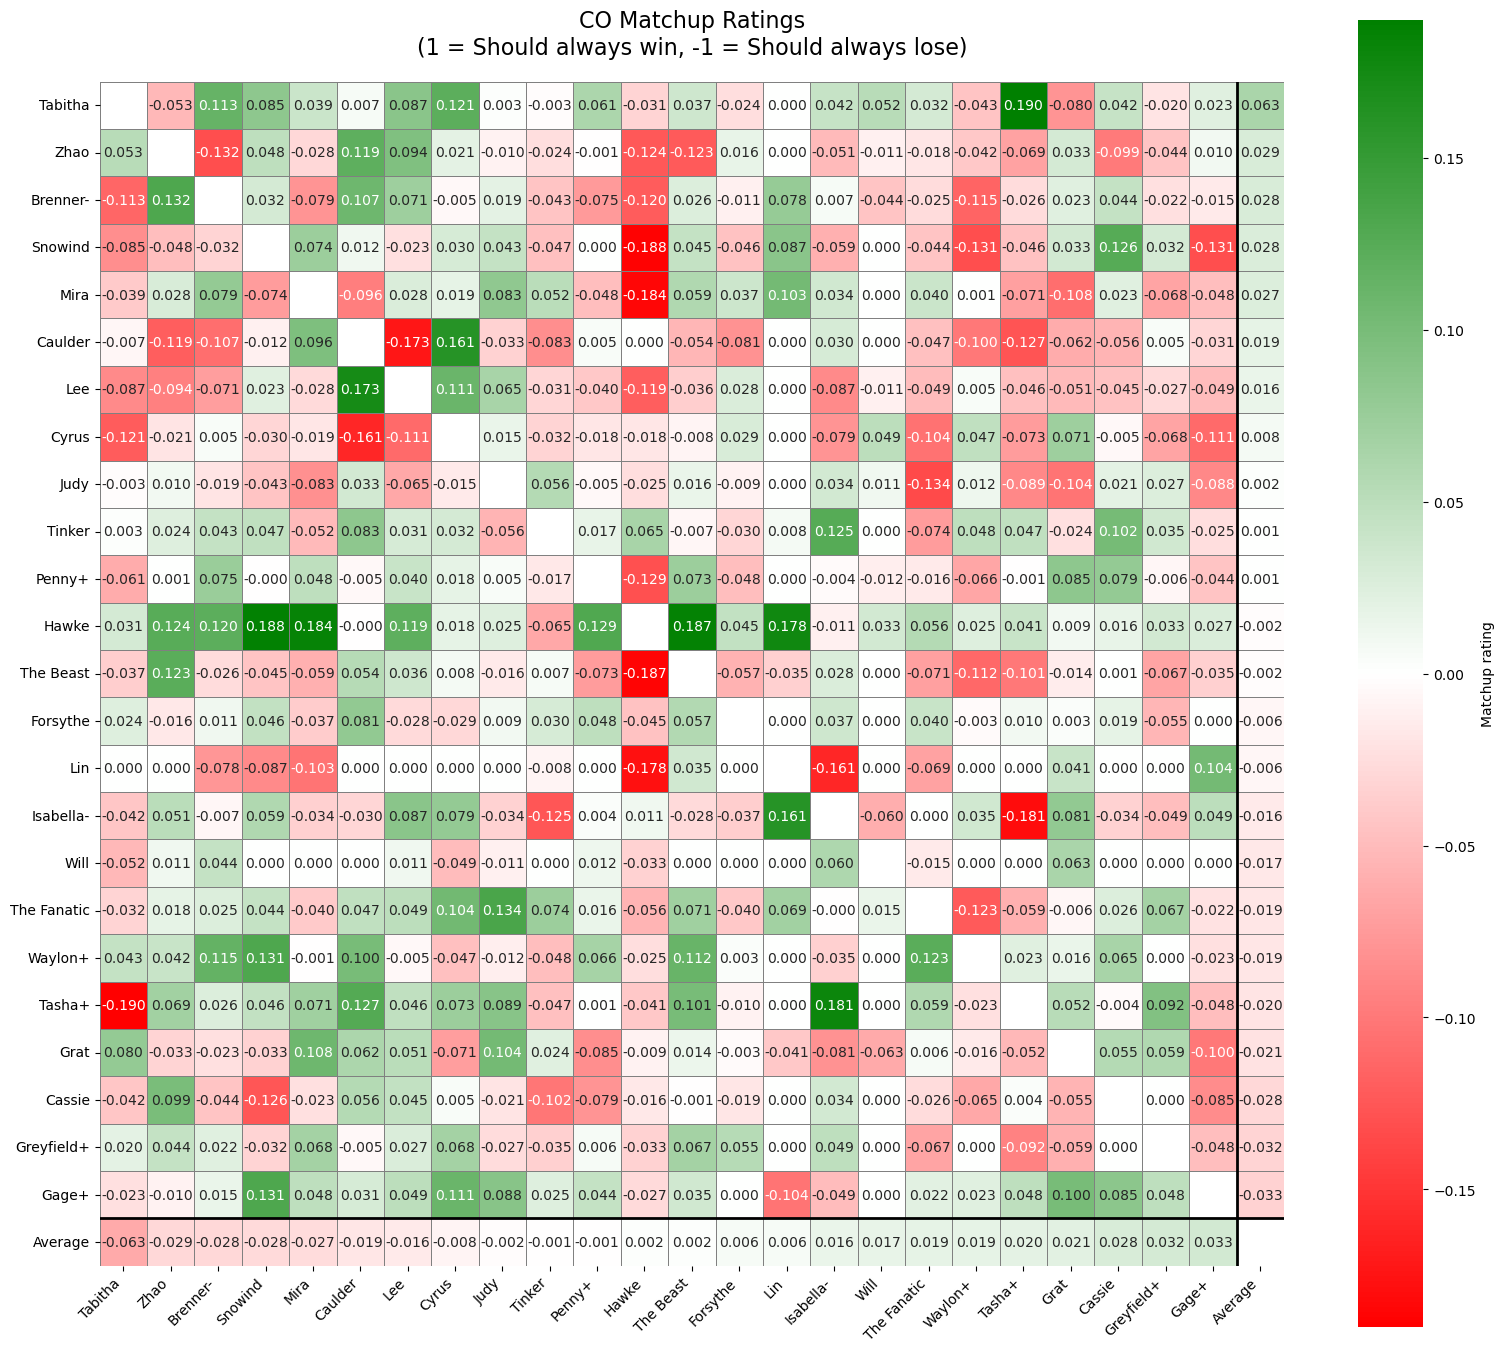

In [9]:
# Sort COs by average rating (descending)
sorted_cos = avg_ratings.sort_values(ascending=False).index.tolist()

display_heatmap(
    'CO Matchup Ratings\n(1 = Should always win, -1 = Should always lose)',
    'Matchup rating',
    matchup_df,
    sorted_cos,
    avg_ratings[sorted_cos],
)

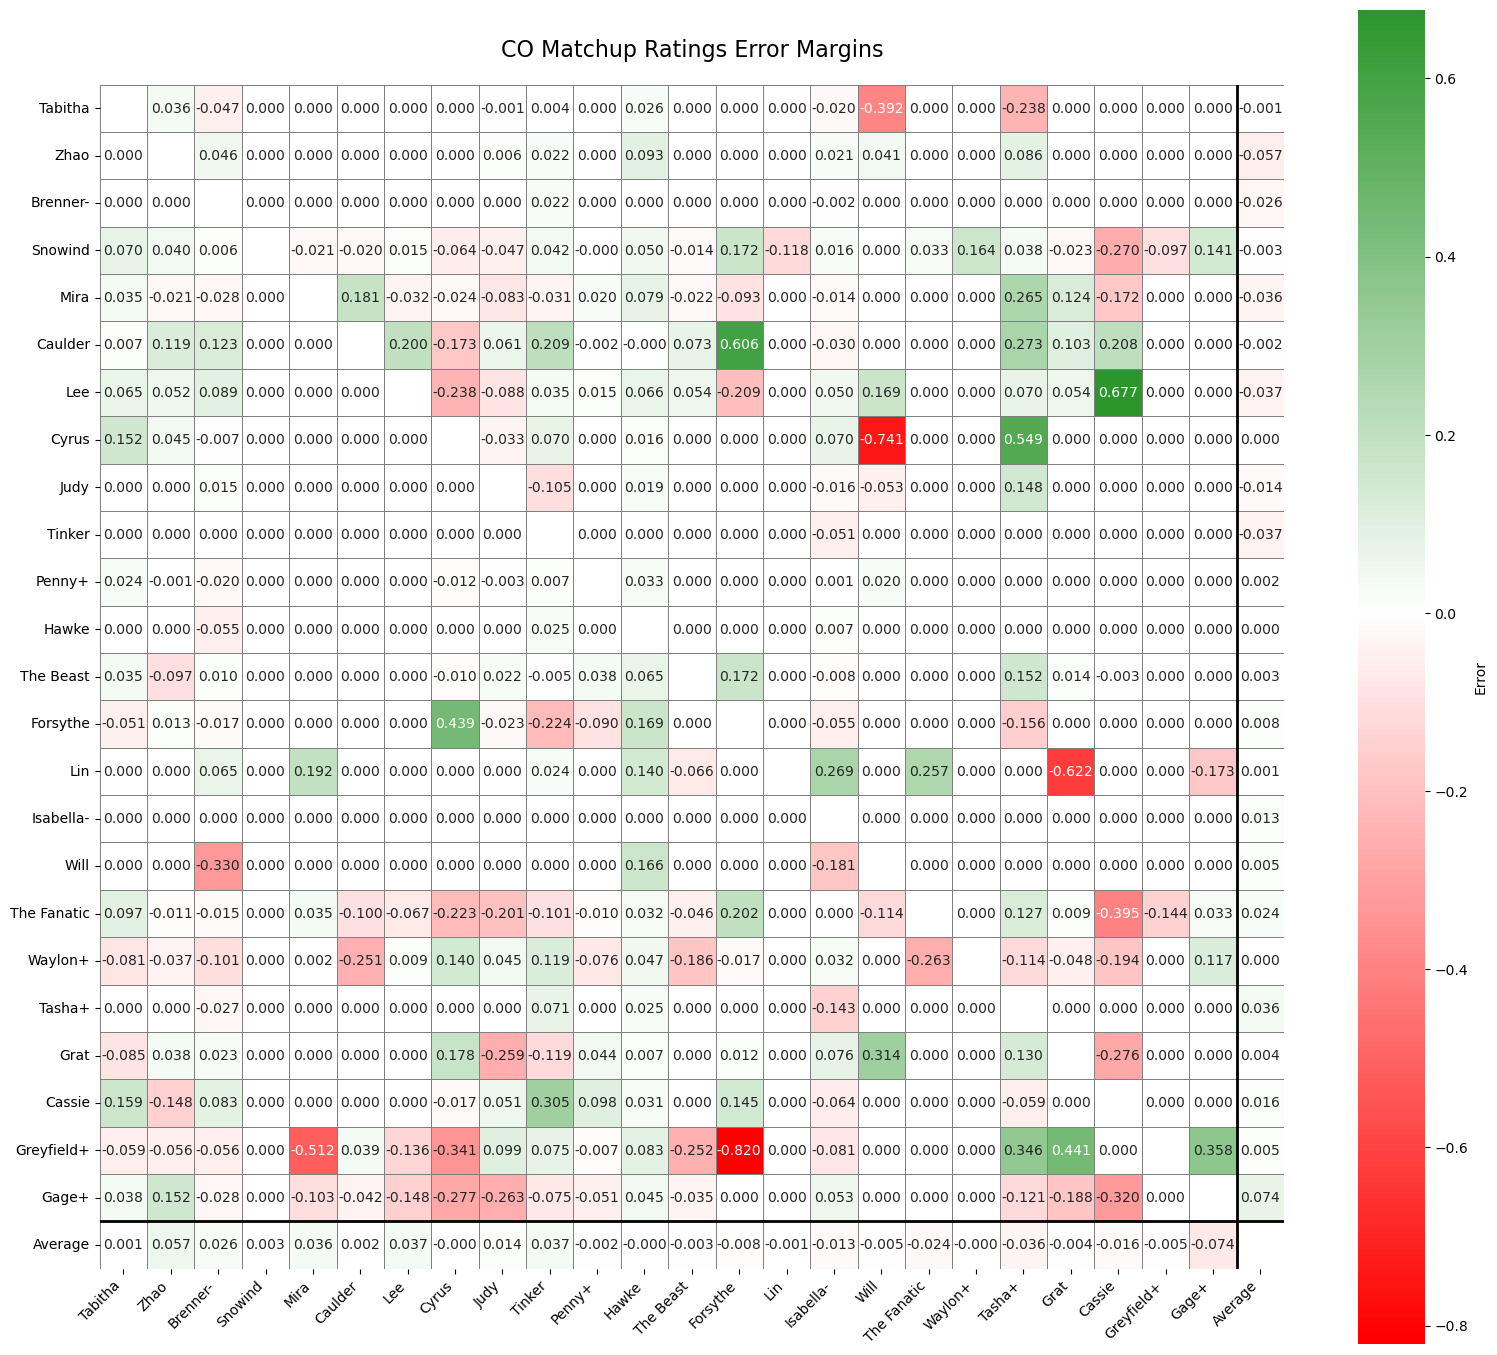

In [10]:
display_heatmap(
    'CO Matchup Ratings Error Margins',
    'Error',
    error_df,
    sorted_cos,
    avg_error[sorted_cos],
)

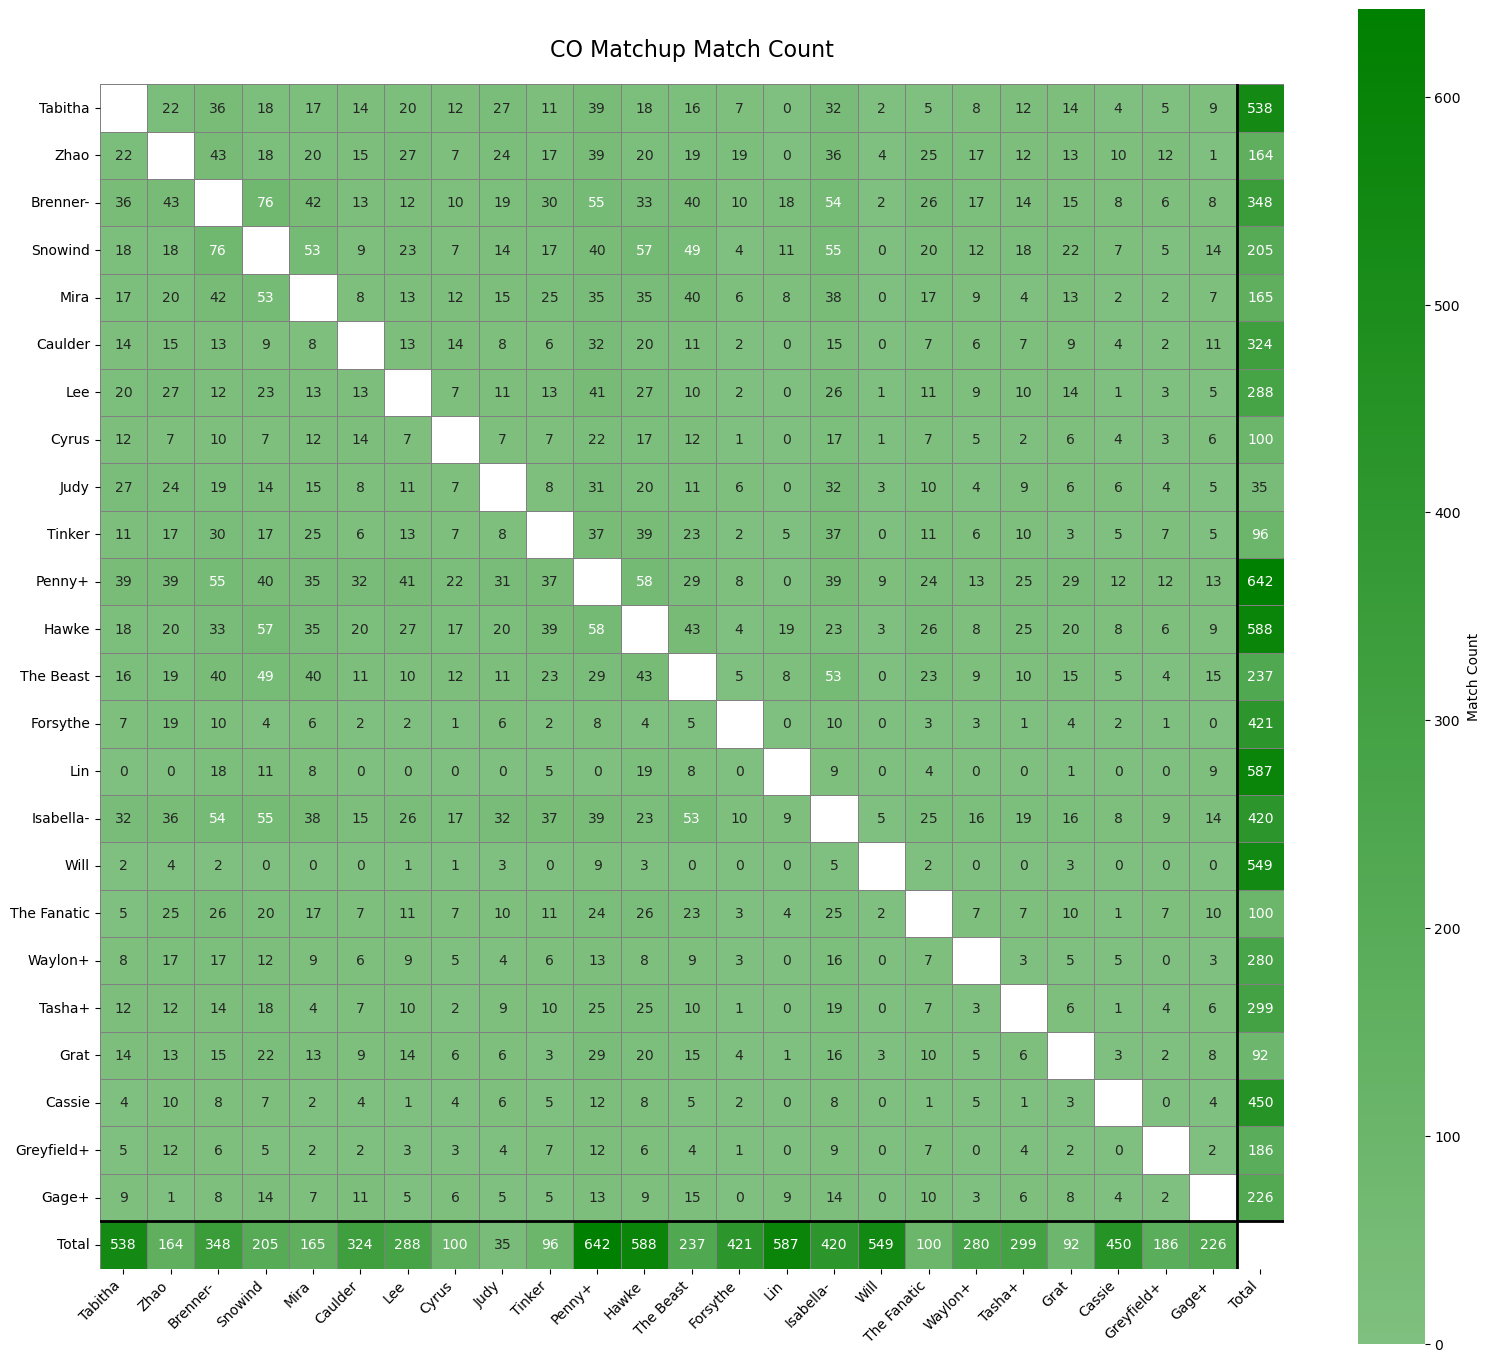

In [11]:
display_heatmap(
    'CO Matchup Match Count',
    'Match Count',
    match_count_df,
    sorted_cos,
    sum_matches[sorted_cos],
    True
)